# Visualization of *Game of Thrones* Season 8 Sentiment

*An accompanying story for this project is available at [Medium.com](https://medium.com/@ryanschubert20/dee82f47e10f).*

The goal of this notebook is to visualize the sentiment of tweets during the final season of HBO's series *Game of Thrones*.

In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords, twitter_samples
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk import FreqDist, classify, NaiveBayesClassifier
import re, string, random

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Import the dataset from the previous notebook where we performed the sentiment analysis
got = pd.read_csv('/content/drive/MyDrive/got_sa.csv')

In [3]:
# Format the datetime column 'created_at' correctly
got['created_at'] = pd.to_datetime(got['created_at'], format='%Y-%m-%d %H:%M:%S')

In [4]:
got.head()

,created_at,text,sentiment
0,2019-04-17 07:34:18,👍 on @YouTube: GAME OF THRONES 8x01 Breakdown!...,Positive
1,2019-04-16 03:34:16,👍 on @YouTube: Ups and Downs From Game Of Thro...,Negative
2,2019-04-16 03:06:08,Liked on YouTube: Ups and Downs From Game Of T...,Negative
3,2019-04-17 07:07:38,Liked on YouTube: GAME OF THRONES 8x01 Breakdo...,Positive
4,2019-04-17 07:34:09,@MrLegenDarius unpopular opinion: game of thro...,Positive


## Setup For Plotting

Before we can look at how the sentiment changed over time, we need to do some tweaking to the dataset first. We will get rid of the text column, as it will not be needed. Then we will adjust the dataset's timezone so that it corresponds to the same timezone (EST) as the episodes time of airing. We will also sort the dataframe by the 'created_at' datetime object and then make that the index for later use. 

In [5]:
# Drop the 'text' column
got = got.drop(['text'], axis=1)

In [6]:
got['created_at'] = got.created_at.dt.tz_localize('UTC').dt.tz_convert('US/Eastern').dt.strftime('%Y-%m-%d %H:%M:%S') # convert from UTC to ET
got['created_at'] = pd.to_datetime(got['created_at'], format='%Y-%m-%d %H:%M:%S') # reformat the datetime correctly

In [7]:
got.head()

,created_at,sentiment
0,2019-04-17 03:34:18,Positive
1,2019-04-15 23:34:16,Negative
2,2019-04-15 23:06:08,Negative
3,2019-04-17 03:07:38,Positive
4,2019-04-17 03:34:09,Positive


We will sort the dataframe by the 'created_at' datetime object for each tweet, and then we will use the 'created_at' column as the index so that it will be easier to group tweets later on by date and time. 

In [8]:
got = got.sort_values(by='created_at') # sort the dataframe by the time of each tweet
got.set_index('created_at', drop=False, inplace=True) # set the time the tweet was created at as the index

## How Does Sentiment Evolve Over the Course of the Final Season?

Now that we have done some preprocessing to the dataset, we can look at how sentiment changed over the weeks leading up to, during, and shortly after the final season of *Game of Thrones*. To do this, we will group the tweets by day and get a count for both positive and negative sentiment. 

To group the tweets by day and sentiment, we will use `.groupby` with a frequency of 1 day and an offset of 12 hours so that we capture tweets immediately after episodes, that may be in the early hours of the next day, in the same day as the episode aired. Using `.value_counts()` will give us the count for positive and negative sentiment.

In [9]:
got_day = pd.DataFrame(got[['created_at', 'sentiment']].groupby(pd.Grouper(freq='1d', offset='12h'))['sentiment'].value_counts())
got_day.rename(columns={'sentiment':'count'}, inplace=True) # rename the columns to be 'sentiment' and 'count' for each day
got_day.reset_index(inplace=True) # reset the index
got_day.head()

,created_at,sentiment,count
0,2019-04-06 12:00:00,Negative,165
1,2019-04-06 12:00:00,Positive,155
2,2019-04-07 12:00:00,Negative,3582
3,2019-04-07 12:00:00,Positive,3013
4,2019-04-08 12:00:00,Negative,4384


The next step is to rearrange the dataframe to better display the number of negative and positive tweets for each day.

In [10]:
# Create new columns for positive and negative sentiment instead of having 'sentiment' and 'count'
got_day = pd.concat([got_day,pd.get_dummies(got_day['sentiment'])], axis=1)

In [ ]:
# Move the count for each sentiment into the new columns so that for each value 
# in the 'created_at' column there is a value for Negative and Positive
for i in range(len(got_day)):
  if got_day['sentiment'].iloc[i] == 'Positive':
    got_day['Positive'].iloc[i] = got_day['count'].iloc[i]
  else:
    got_day['Negative'].iloc[i] = got_day['count'].iloc[i]

In [12]:
got_day.drop(['sentiment', 'count'], axis=1, inplace=True) # drop the old columns
got_day = got_day.groupby('created_at').sum() # combine the separate negative and positive rows into a single row for each day
got_day.reset_index(inplace=True)
got_day.head()

,created_at,Negative,Positive
0,2019-04-06 12:00:00,165,155
1,2019-04-07 12:00:00,3582,3013
2,2019-04-08 12:00:00,4384,3601
3,2019-04-09 12:00:00,4515,3751
4,2019-04-10 12:00:00,4718,3874


Above, is our dataframe rearranged so that we can see each day and the number of tweets for each sentiment.

In [13]:
got_day.describe()

,Negative,Positive
count,52.000000,52.000000
mean,8635.057692,5993.019231
std,10754.008570,6269.775042
min,165.000000,155.000000
25%,3367.500000,2515.750000
50%,4518.500000,3781.000000
75%,7946.500000,6248.750000
max,47895.000000,32276.000000


Using `.describe()` we can see that there are 52 days in this dataset. The mean number of negative and positive tweets per day is 8635 and 5993, respectively. So on average there are more negative tweets than positive ones, but we will see if that varies day to day. 

In [14]:
# Correct the 'created_at' time back to the beginning of each day 
# This accounts for the offset when grouping and helps with plotting
got_day['created_at'] = got_day['created_at'] - timedelta(hours=12)

Finally, we will plot the count of negative and positive tweets by day and see how the sentiment evolves over time.

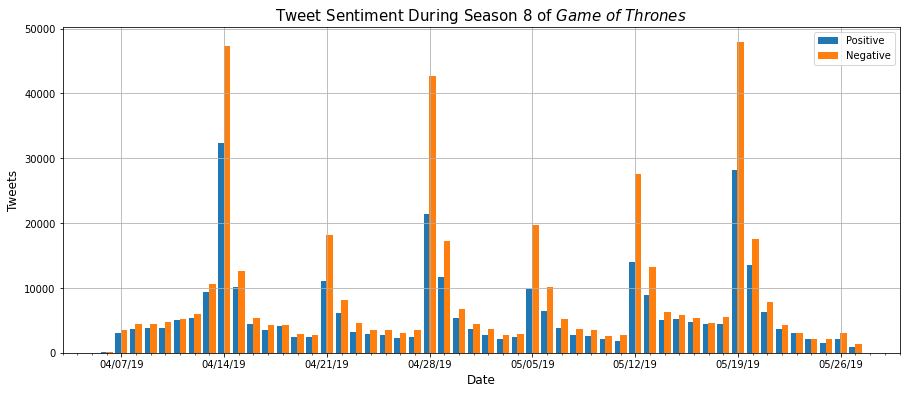

In [15]:
x = timedelta(hours=4.5) # used to offset the positive tweets to compare side by side

fig, ax = plt.subplots(1, 1, figsize=(15,6))
pos = ax.bar(got_day['created_at']-x, got_day['Positive'], width=0.45, align='center', label='Positive')
neg = ax.bar(got_day['created_at']+x, got_day['Negative'], width=0.45, align='center', label='Negative')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.SUNDAY, interval=1)) # set major tick labels to be on Sundays
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.set_title('Tweet Sentiment During Season 8 of $\it{Game}$ $\it{of}$ $\it{Thrones}$', fontsize=15)
ax.legend()
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Tweets', fontsize=12)
ax.grid()

This plot shows the number of tweets per day during the time the final season of *Game of Thrones* was running. The most notable feature is that tweets spike on the day of episodes. This is due to people being excited for the episode, tweeting during the episode, and commenting their thoughts after the episode is over. Another key feature is that every day has more negative tweets than positive tweets, with an exception where it looks like they may have the same amount on May 23rd and 24th. This is not what I was expecting. I was expecting to see a shift back and forth as time went on. I would have also thought that tweets leading up to the first episode would be mostly positive as people were excited for the final season. It could be that a majority of tweets did have a negative sentiment towards the show, but it could also be that the dataset we used to train the model wasn't a great fit for the *Game of Thrones* dataset. The final feature of interest is how the number of tweets changes in the days before/after an episode. For episodes 2-6, the number of tweets, both negative and positive, generally decreases every day until the day of the next episode. However, for episode 1 the tweets increase each day leading up to its airing. 

## How Does Sentiment Evolve Over the Course of Each Episode?

Similar to the previous section, in this section we will look at the sentiment of tweets in the hours leading up to, during, and following each episode. 

Similarly, we will group the tweets into 15 minute intervals for both negative and positive sentiment. We will again use `.value_counts()` to give us the count for positive and negative sentiment.

In [16]:
got_hr = pd.DataFrame(got[['created_at', 'sentiment']].groupby(pd.Grouper(freq='15Min'))['sentiment'].value_counts())
got_hr.rename(columns={'sentiment':'count'}, inplace=True) # rename the columns to be 'sentiment' and 'count' for each day
got_hr.reset_index(inplace=True) # reset the index
got_hr.head()

,created_at,sentiment,count
0,2019-04-07 10:15:00,Negative,3
1,2019-04-07 10:15:00,Positive,1
2,2019-04-07 10:30:00,Negative,3
3,2019-04-07 10:30:00,Positive,1
4,2019-04-07 10:45:00,Positive,10


Just like before, we will rearrange the dataframe in a more useful way for each 15 minute time block.

In [17]:
# Create new columns for positive and negative sentiment
got_hr = pd.concat([got_hr,pd.get_dummies(got_hr['sentiment'])], axis=1)

In [ ]:
# Move the count for each sentiment into the new columns so that for each value 
# in the 'created_at' column there is a value for Negative and Positive
for i in range(len(got_hr)):
  if got_hr['sentiment'].iloc[i] == 'Positive':
    got_hr['Positive'].iloc[i] = got_hr['count'].iloc[i]
  else:
    got_hr['Negative'].iloc[i] = got_hr['count'].iloc[i]

In [19]:
got_hr.drop(['sentiment', 'count'], axis=1, inplace=True) # drop the old columns
got_hr = got_hr.groupby('created_at').sum() # combine the separate negative and positive rows into a single row for each time block
got_hr.reset_index(inplace=True)
got_hr.head()

,created_at,Negative,Positive
0,2019-04-07 10:15:00,3,1
1,2019-04-07 10:30:00,3,1
2,2019-04-07 10:45:00,8,10
3,2019-04-07 11:00:00,37,31
4,2019-04-07 11:15:00,28,31


Now that we've rearranged our dataframe, we will look at how the sentiment of tweets evolved over each episode. 

Text(0.5, 0.98, 'Sentiment of Tweets During $\\it{Game}$ $\\it{of}$ $\\it{Thrones}$ Episodes')

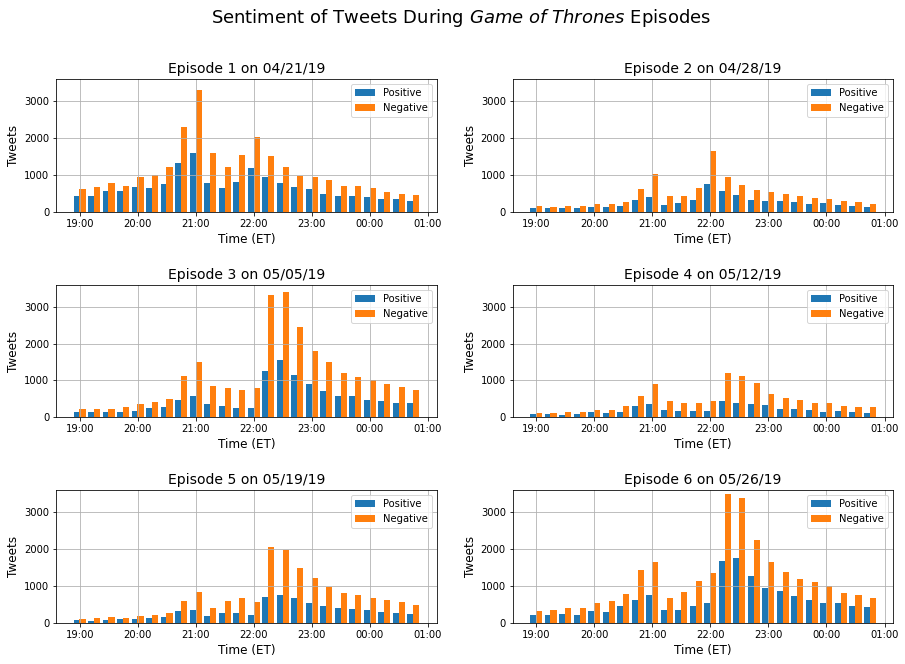

In [20]:
x = timedelta(hours=0.05)
y = 672 # time between episodes (7 days)

z = 0 # a multiplier used to help move to the next episode
fig, axs = plt.subplots(3, 2, figsize=(15,10))
plt.subplots_adjust(hspace=0.55)
for ax in axs.ravel():
  ax.bar(got_hr['created_at'][707+(y*z):731+(y*z)]-x, got_hr['Positive'][707+(y*z):731+(y*z)], width=0.0045, align='center', label='Positive') # y*z will add the necessary number of indeces
  ax.bar(got_hr['created_at'][707+(y*z):731+(y*z)]+x, got_hr['Negative'][707+(y*z):731+(y*z)], width=0.0045, align='center', label='Negative') # to get to the current episode in the loop
  ax.xaxis.set_major_locator(mdates.HourLocator(byhour=None, interval=1))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
  ax.axis(ymin=0, ymax=3600)
  ax.grid()
  z = z + 1
  date = got_hr['created_at'][707+(y*z)].date() # get the date of the episode
  ax.set_title('Episode {} on {}'.format(z, date.strftime('%m/%d/%y')), fontsize=14) # format each subplot for it's corresponding episode
  ax.set_xlabel('Time (ET)', fontsize=12)
  ax.set_ylabel('Tweets', fontsize=12)
  ax.legend()
fig.suptitle('Sentiment of Tweets During $\it{Game}$ $\it{of}$ $\it{Thrones}$ Episodes', fontsize=18)

The most noticeable feature about these plots, just like when looking at the daily dataset, each time block here has more negative tweets than positive ones. I would think that there should be at least some moments before, during, or after an episode where sentiment is more positive than negative. So, again, maybe the dataset used to train this model isn't perfect. We can also see that the first, third, and sixth episodes were the most tweeted about. This makes sense because people were excited about the new season in the first episode, the protagonists fought the white walkers, and the sixth episode was the final episode of the entire series. It's also interesting to note how the number of tweets evolved during each episode. Each episode began at 21:00 ET and during the first episode there was quite a lot of tweeting. However, during the third episode, once it began, the tweets started decreasing until immediately afterward. This difference could highlight different levels of engagement with the different episodes.